# Calculo de las metricas

En este archivo se analizan las trazas guardadas en varios archivos json

In [66]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Lectura del documento

In [67]:
# Ruta de los archivos con los datos obtenidos por el "Tracking system"
path = './DataTracker'

In [68]:
def loadJsonData(path):
    jsonData = []
    
    # Obtener lista de archivos en la carpeta
    jsonFiles = os.listdir(path)
    
    # Recorrer y filtrar solo los archivos JSON
    for file in jsonFiles:
        if file.endswith('.json'):
            file_path = os.path.join(path, file)
            
            # Comprobar nombre de mapa, ahora mismo lee todos los JSON
            
            # Leer el contenido del archivo JSON
            with open(file_path, 'r', encoding='utf-8') as f:
                info = json.load(f)
                jsonData.extend(info)
    
    return jsonData

In [69]:
# Leer los archivos JSON y obtener su información
data = loadJsonData(path)

# Se ordena la información del documento en base el timestamp
sorted_data = sorted(data, key=lambda x: x['timestamp'])

### Parseo de Eventos

In [70]:
# Numero total de eventos
num_events = len(sorted_data)
# Indice de eventos
index = 0
sessions = []
sesion = 0
test_list = []
test = 0
pos_list = []

In [71]:
def parseEvent(event):
    global test_list
    global pos_list
    global sesion
    global test
    global sessions
    if event['typeEvent'] == "LoginEvent":
        test = 0
    elif event['typeEvent'] == "LogoutEvent":
        sessions.append(test_list.copy())
        test_list.clear()
        sesion += 1
    # Acaba el test
    elif event['typeEvent'] == "EndTestEvent":
        test_list.append(pos_list.copy())
        pos_list.clear()
        test += 1
    #Evento de movimeinto de un bot
    elif event['typeEvent'] == "BotPositionEvent":
        pos_list.append(event)
    return  True

In [72]:
# Recorro todos los eventos generados
while index < num_events:
    currentEvent = sorted_data[index]
    consumeEvent = parseEvent(currentEvent)
    index += 1

### Mapa de calor con las posiciones y porcentaje

En este archivo se analizan de forma total los mapas. Es decir, se genera un mapa de calor para todas las sesiones de forma conjunta y se calcula el porcentaje de cobertura de esta forma también.

Esta opción debe tomarse si se quiere un nivel de visión general.

#### Calculo del porcentaje

In [73]:
# Función para calcular el % de mapa recorrido
def calculate_visited_area(positions):
    x_cells = np.linspace(0, map_size, cellsize+1)
    y_cells = np.linspace(0, map_size, cellsize+1)
    visited_cells = set()
    
    for _, row in positions.iterrows():
        x, y = row['posX'], row['posZ']
        x = max(0, min(map_size, x)) # Me aseguro que la coordenada este dentro de los limites del mapa
        y = max(0, min(map_size, y)) # Me aseguro que la coordenada este dentro de los limites del mapa
        #print(f'x: {x}')
        x_bin = np.digitize(x, x_cells) - 1
        #print(f'indice: {x_bin}')
        y_bin = np.digitize(y, y_cells) - 1
        #Me aseguro que este dentro de los limites de la grid
        if 0 <= x_bin < cellsize and 0 <= y_bin < cellsize:
            visited_cells.add((x_bin, y_bin))
    
    n_cells_visited = len(visited_cells) #Numero de casillas visitadas
    gridsize = cellsize * cellsize #Total ed casillas
    percentage_visited = (n_cells_visited / gridsize) * 100
    return percentage_visited


#### Creacion del mapa de calor

In [74]:
map_name = "map2"

 95.60% del mapa cubierto


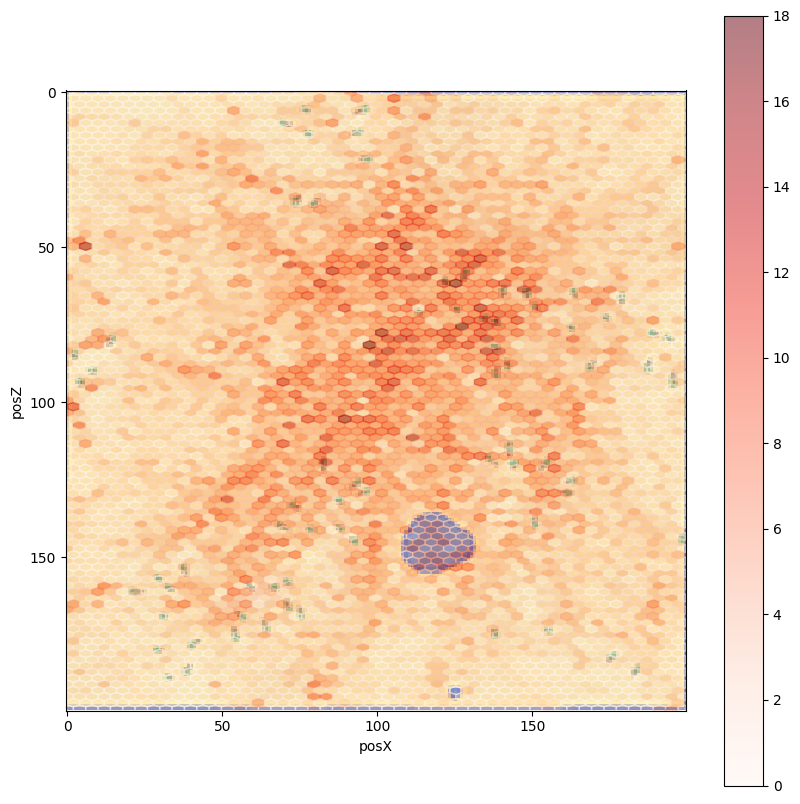

In [75]:
# Guardar la imagen del mapa
img = plt.imread(f'images/{map_name}.png')

# Dimensiones del mapa
map_size = 200
#Divido el mapa en casillas
cellsize = 50


dfTest = pd.DataFrame()
for i, currentSession in enumerate(sessions):
    for j, currentTest in enumerate(currentSession):
        dfTest = pd.concat([dfTest, pd.DataFrame(currentTest)])

# Calcular el porcentaje del área recorrida
percentage_visited = calculate_visited_area(dfTest)
# Imprimir el porcentaje del área recorrida
print(f' {percentage_visited:.2f}% del mapa cubierto')
                
# Definir las dimensiones del mapa
fig,ax = plt.subplots(figsize=(10,10)) #Tamaño en pulgadas de la imagen cuando se guarde
ax.imshow(img)
# Dibujar el mapa de calor
dfTest.plot.hexbin(fig = fig, ax = ax,x="posX", y="posZ", reduce_C_function=sum, gridsize=(50,50), extent=[0,199,0,199], alpha=0.5, cmap='Reds')
ax.set_xticks(range(0, 199, 50))
ax.set_yticks(range(0, 199, 50))
fig.savefig(f'heatmaps/{map_name}/heatmapAllSessionsMerge.png')